# ИД23-1 Маслов АН

# Dask DataFrame

Материалы:
* Макрушин С.В. Лекция 13: Dask DataFrame
* https://docs.dask.org/en/latest/dataframe.html
* JESSE C. DANIEL. Data Science with Python and Dask.

In [1]:
import dask.dataframe as dd
import pandas as pd
import dask.bag as db
import json
import dask

## Лабораторная работа 13

1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [3]:
from google.colab import files
f1 = files.upload()
nf = list(f1.keys())[0]  # имя загруженного файла
recipes = dd.read_csv(nf,  parse_dates=['submitted'])

Saving recipes_sample.csv to recipes_sample.csv


2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [4]:

print("Метаинформация о таблице: ")
print(recipes.info())

Метаинформация о таблице: 
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 8 entries, name to n_ingredients
dtypes: datetime64[ns](1), float64(2), int64(3), string(2)None


3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [5]:
recipes.head(5)

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,george s at the cove black bean soup,44123,90,35193,2002-10-25,NaN,an original recipe created by chef scott meska...,18.0
1,healthy for them yogurt popsicles,67664,10,91970,2003-07-26,NaN,my children and their friends ask for my homem...,NaN
2,i can t believe it s spinach,38798,30,1533,2002-08-29,NaN,"these were so go, it surprised even me.",8.0
3,italian gut busters,35173,45,22724,2002-07-27,NaN,my sister-in-law made these for us at a family...,NaN
4,love is in the air beef fondue sauces,84797,25,4470,2004-02-23,4.0,i think a fondue is a very romantic casual din...,NaN


In [6]:
recipes.tail(5)

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients
29995,zurie s holey rustic olive and cheddar bread,267661,80,200862,2007-11-25,16.0,this is based on a french recipe but i changed...,10.0
29996,zwetschgenkuchen bavarian plum cake,386977,240,177443,2009-08-24,NaN,"this is a traditional fresh plum cake, thought...",11.0
29997,zwiebelkuchen southwest german onion cake,103312,75,161745,2004-11-03,NaN,this is a traditional late summer early fall s...,NaN
29998,zydeco soup,486161,60,227978,2012-08-29,NaN,this is a delicious soup that i originally fou...,NaN
29999,cookies by design cookies on a stick,298512,29,506822,2008-04-15,9.0,"i've heard of the 'cookies by design' company,...",10.0


4. Посчитайте, сколько строк содержит каждый из блоков

In [7]:
recipes.map_partitions(lambda x: x).map_partitions(lambda recipes: recipes.shape[0]).compute()

,0
0,30000


5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` в этом случае.

Максимум в столбце n_steps: 88.0



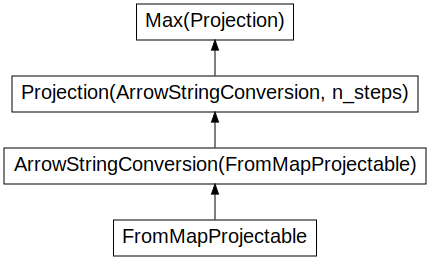

In [8]:
print("Максимум в столбце n_steps: " + str(recipes['n_steps'].max().compute()))
print()
recipes['n_steps'].max().visualize()

6. Посчитайте количество отзывов с группировкой по месяцам добавления отзыва в базу.

In [9]:
#подсчёт количества рецептов с группировкой по месяцу и сортировку по месяцам
recipes_count = recipes['name'].groupby([recipes.submitted.dt.month]).agg('count').compute().sort_index()
recipes_count


,name
submitted,
1,2628
2,2420
3,2667
4,2689
5,2853
6,2366
7,2447
8,2457
9,2423


7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [10]:
f1 = files.upload()
nf = list(f1.keys())[0]  # имя загруженного файла


Saving reviews_sample.csv to reviews_sample.csv


In [51]:
import dask.dataframe as dd
import dask.bag as db
from dask import delayed
import pandas as pd
ddf = dd.read_csv(nf,
                  assume_missing=True,
                  parse_dates=['date'],
                 )

ddf['rating'] = dd.to_numeric(ddf['rating'], errors='coerce')
ddf = ddf.dropna(subset=['date', 'rating'])
ddf['month'] = ddf['date'].dt.month
ddf_small = ddf[['month', 'rating']]

# Преобразуем партиции ddf в delayed объекты (каждый delayed вернёт pandas.DataFrame)
delayed_parts = ddf_small.to_delayed()

# Для каждой delayed-партиции создаём delayed-функцию, которая превращает DataFrame
# в список кортежей (month, rating)
def df_to_tuples(pdf):
    return list(zip(pdf['month'].astype(int), pdf['rating'].astype(float)))

delayed_lists = [delayed(df_to_tuples)(d) for d in delayed_parts]
bag = db.from_delayed(delayed_lists)

# bag состоит из элементов (month, rating)

grouped = bag.groupby(lambda x: x[0])

def mean_for_group(kv):
    month, items = kv  # items — (month, rating)
    ratings = [it[1] for it in items]
    if not ratings:
        return (month, float('nan'))
    return (month, sum(ratings) / len(ratings))

mean_by_month_bag = grouped.map(mean_for_group)
result_dict = dict(mean_by_month_bag.compute())
mean_rating = pd.Series(result_dict).sort_index()
mean_rating.name = 'rating'

print(mean_rating)


1     4.410949
2     4.388373
3     4.371598
4     4.426995
5     4.447297
6     4.440987
7     4.412182
8     4.431176
9     4.406560
10    4.426746
11    4.384691
12    4.384484
Name: rating, dtype: float64


8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [52]:
#конкатенация двух таблиц и изменение названий колонок
df = pd.concat([mean_rating, recipes_count], axis=1).rename(columns = {'rating' : 'mean_rating', 'name':'recipes_count'}).sort_index()
df

,mean_rating,recipes_count
1,4.410949,2628
2,4.388373,2420
3,4.371598,2667
4,4.426995,2689
5,4.447297,2853
6,4.440987,2366
7,4.412182,2447
8,4.431176,2457
9,4.406560,2423
10,4.426746,2472
